# Predicting Chest Pain Type for Heart Disease Patients  based on their Resting Blood Pressure and Cholesterol Level

## Introduction

#### Background Information
Chest pain (angina)¹ is the most obvious symptom of heart disease. High cholesterol and high blood pressure are major factors that induce chest pain because both affect coronary arteries that supply the heart with blood.

Research has shown that high cholesterol causes accumulation on the artery walls, further reduces artery blood flow, and causes complications like chest pain². Also, high blood pressure damages arteries by reducing elasticity, which decreases blood and oxygen flow to the heart, and leads to chest pain³. 

Scientists define cholesterol level above 240 mg/dl as high and dangerous⁴, and systolic pressure (artery pressure when heart beats) above 130mmHg as hypertension³. Blood pressure in this project is systolic pressure.


#### Dataset Description + Question we try to answer
In our project, we use the Cleveland database in the UCI Heart Disease Data Set ([Kaggle link to dataset](https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci?resource=download)). It contains 14 attributes and information supported by Cleveland Clinic Foundation. We aim to predict chest pain type for heart disease patients from their blood pressure and cholesterol values.

In [1]:
install.packages("themis")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(themis)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)
### Also set the seed
set.seed(2022)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### METHOD & RESULTS

#### EXPLORATORY DATA ANALYSIS

The original data set has 14 columns, which contains information about the patient's chest pain type along with other heart data. After our preliminary data analysis, we have decided that there are 4 columns that are relevant to our question. The following 4 columns and their definition (according to the website) are:
1. **cp**: Patient's chest pain type:
    - 0: typical angina
    - 1: atypical angina
    - 2: non-anginal pain
    - 3: asymptomatic
2. **trestbps**: Patient's resting blood pressure (in mmHg on admission to the hospital).
3. **chol**: Patient's serum cholesterol in mg/dl.

In [3]:
set.seed(2022)
### Code block
# Loading data
heart_cleveland_data <- read_csv("https://raw.githubusercontent.com/soph-ien/dsci_100_group143_project/main/heart_cleveland_upload.csv") |> 
                        mutate(across(c(sex:cp, fbs:restecg, exang, slope:condition), as_factor))

# Filtering for people with a heart condition
heart_cleveland_data_filter <- filter(heart_cleveland_data, condition == 1)

# Spliting the data into training and test data
heart_split <- initial_split(heart_cleveland_data_filter, prop = 0.75, strata = cp)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

# Investigate the proportion of each cp types in the training data
heart_proportion_train <- heart_train |> group_by(cp) |> summarize(n=n()) |> mutate(percent = 100*n/nrow(heart_train))

# Investigate if there's any missing values
heart_missing_data_train <- as_tibble(apply(heart_train, 2, is.na)) |> map_df(sum)

# Plotting the distribution of resting blood pressure for each type of chest pain via histograms
options(repr.plot.width = 8, repr.plot.height = 8) 
heart_train_cp_plot <- heart_train |> ggplot(aes(x = trestbps, fill = cp)) +
                                        geom_histogram(bins = 25) +
                                        labs(x = "Resting blood pressure (mmHg)", y = "Number of patients", fill = "Chest pain type") +
                                        theme(text = element_text(size = 15)) +
                                        scale_x_continuous(breaks = seq(90, 200, by = 10))


Rows: 297 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
61,1,0,134,234,0,0,145,0,2.6,1,2,0,1
59,1,0,170,288,0,2,159,0,0.2,1,0,2,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
39,1,3,118,219,0,0,140,0,1.2,1,0,2,1
35,1,3,120,198,0,0,130,1,1.6,1,0,2,1
35,1,3,126,282,0,2,156,1,0.0,0,0,2,1


cp,n,percent
<fct>,<int>,<dbl>
0,7,6.862745
1,6,5.882353
2,13,12.745098
3,76,74.509804


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,0,0,0,0


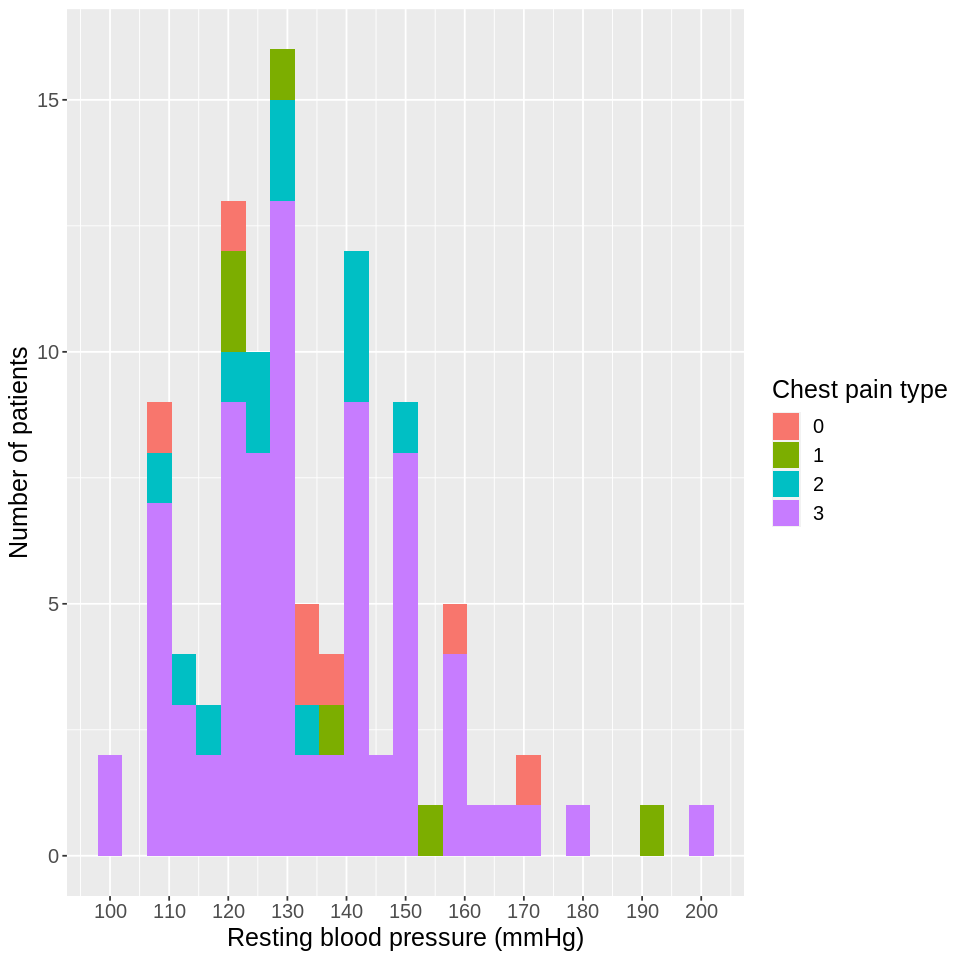

In [4]:
### Load block
heart_cleveland_data_filter
heart_proportion_train
heart_missing_data_train
heart_train_cp_plot

##### ***SUMMARY OF EXPLORATORY DATA ANALYSIS***:

In our training data, most patients have type 3 chest pain (asymptomatic, 74.51%), followed by type 2 (non-anginal pain, 12.75%), then type 0 (typical angina, 6.86%) and finally type 1 (atypical angina, 5.88% ). There is an imbalance in the distribution for chest pain type, so we need to balance them before we start our classification. Next, we examine the presence of missing values in the training set. Results show there are no missing values, so no further steps are needed to remove them.

Lastly, to visualize patients number and their resting blood pressure (testpbs), we create a histogram with trestbps on x-axis and number of patients on y-axis. We color the chest pain type to emphasize the distribution across various values of RBP. From the histogram, most heart disease patients have RBP ranging from 110 to 150 mmHg. We also found the number of asymptomatic chest pain patients are broadly spread out with a range of 110-170 mmHg.

#### METHOD

Explanation leading to making upscale recipe here

In [5]:
set.seed(2022)
# upscaling
upscale_recipe <- recipe(cp ~ ., data = heart_train) |>
                step_upsample(cp, over_ratio = 1, skip = FALSE) |> prep()
upscaled_data <- upscale_recipe |> bake(heart_train)
upscaled_data

age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition,cp
<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
59,1,134,204,0,0,162,0,0.8,0,2,0,1,0
65,1,138,282,1,2,174,0,1.4,1,1,0,1,0
45,1,110,264,0,0,132,0,1.2,1,0,2,1,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
40,1,110,167,0,2,114,1,2.0,1,0,2,1,3
39,1,118,219,0,0,140,0,1.2,1,0,2,1,3
35,1,120,198,0,0,130,1,1.6,1,0,2,1,3


Explanation leading to workflow here

In [6]:
set.seed(2022)

# create spec
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# cross-validation, 5 folds
heart_vfold <- vfold_cv(upscaled_data, v = 5, strata = cp)

k_vals <- tibble(neighbors = seq(from = 1, to = 100))

# create the centering / scaling recipe
uc_recipe <- recipe(cp ~ trestbps + chol + oldpeak, data = upscaled_data) |>
              step_scale(all_predictors()) |>
              step_center(all_predictors())

knn_results <- workflow() |>
               add_recipe(uc_recipe) |>
               add_model(knn_spec) |>
               tune_grid(resamples = heart_vfold, grid = k_vals) |>
               collect_metrics()

Explanation leading to plotting accuracy graph here

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.91125,5,0.017022249,Preprocessor1_Model001
2,accuracy,multiclass,0.91125,5,0.017022249,Preprocessor1_Model002
3,accuracy,multiclass,0.83875,5,0.009762812,Preprocessor1_Model003
⋮,⋮,⋮,⋮,⋮,⋮,⋮
98,accuracy,multiclass,0.2918750,5,0.03827951,Preprocessor1_Model098
99,accuracy,multiclass,0.3052083,5,0.04381196,Preprocessor1_Model099
100,accuracy,multiclass,0.3018750,5,0.04210241,Preprocessor1_Model100


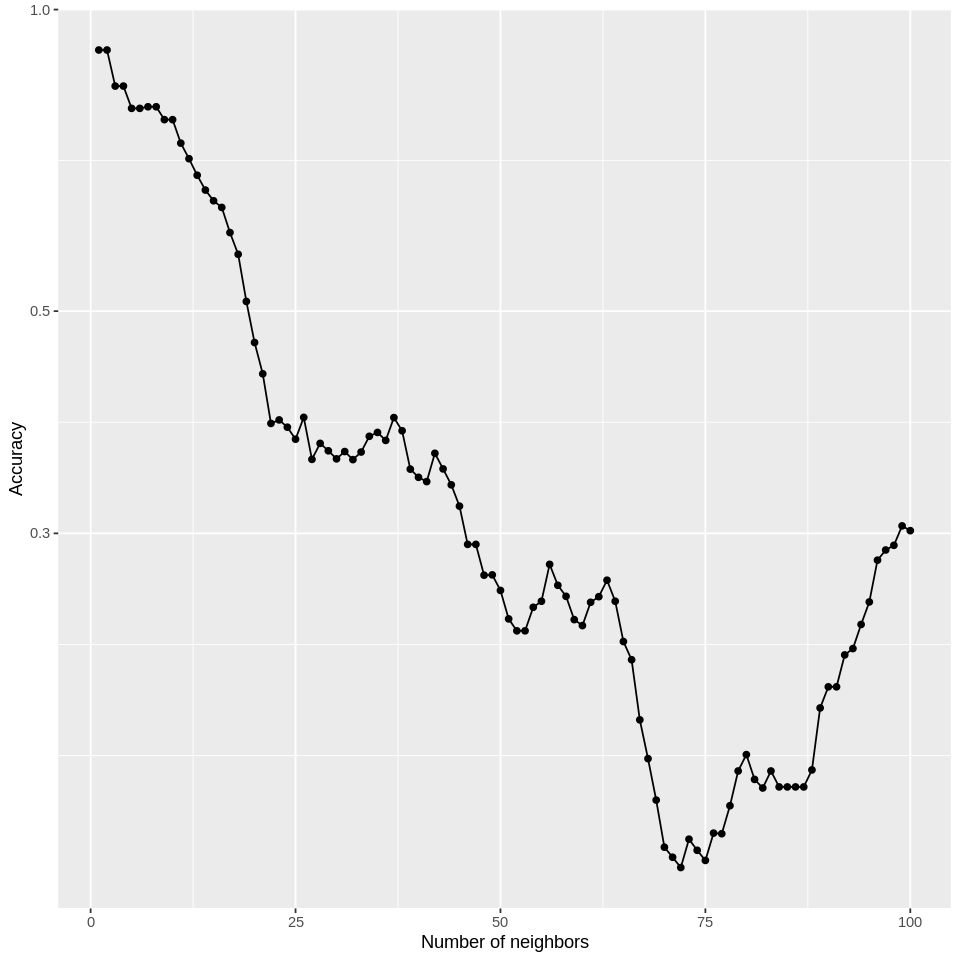

In [7]:
accuracies <- knn_results |> filter(.metric == "accuracy")
accuracies

accuracies_plot <- accuracies |> ggplot(aes(x = neighbors, y = mean)) +
                                 labs(x = "Number of neighbors", y = "Accuracy") +
                                 geom_point() +
                                 geom_line() +
                                 scale_y_log10()

accuracies_plot

Explanation about which k to choose go here

#### RESULTS

### DISCUSSION

### REFERENCES

Data set source : (https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci?resource=download)